<a href="https://colab.research.google.com/github/dropthejase/ml_training/blob/main/neural_networks/rnn_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [14]:
# Load dataset
train_dataset = torchvision.datasets.MNIST(root = ".",
                                           train = True,
                                           transform = transforms.ToTensor(),
                                           download = True)

test_dataset = torchvision.datasets.MNIST(root = ".",
                                           train = False,
                                           transform = transforms.ToTensor(),
                                           download = True)

batch_size = 128

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [16]:
# RNN
class RNN(nn.Module):
  def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
    super(RNN, self).__init__()
    self.D = n_inputs
    self.M = n_hidden
    self.L = n_rnnlayers
    self.K = n_outputs
  
    self.rnn = nn.LSTM(self.D,
                       self.M,
                       self.L,
                       batch_first = True)
    
    self.fc = nn.Linear(self.M, self.K)
  
  def forward(self, X):
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    out, _ = self.rnn(X, (h0, c0))
    out = self.fc(out[:, -1, :])
    return out

In [17]:
model = RNN(28, 128, 2, 10)
model.to(device)

RNN(
  (rnn): LSTM(28, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)

In [18]:
criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters())

In [19]:
n_epochs = 10

train_losses = np.zeros(n_epochs)
test_losses = np.zeros(n_epochs)

for it in range(n_epochs):

  # training
  train_loss = []
  for inputs, targets in train_loader:
    inputs, targets = inputs.to(device), targets.to(device)

    inputs = inputs.view(-1, 28, 28) # need to reshape tensor of (128, 1, 28, 28) to (128, 28, 28)

    optimiser.zero_grad()

    p_train = model(inputs) # provides N x K

    loss = criterion(p_train, targets)

    loss.backward()
    optimiser.step()

    train_loss.append(loss.item())
  
  # testing
  test_loss = []
  for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)

    inputs = inputs.view(-1, 28, 28)

    p_test = model(inputs)
    loss = criterion(p_test, targets)

    test_loss.append(loss.item())
  
  train_losses[it] = np.mean(train_loss)
  test_losses[it] = np.mean(test_loss)


  print(f'Epochs: {it+1}, Train Loss: {train_losses[it]:.4f}, Test Loss: {test_losses[it]:.4f}')


Epochs: 1, Train Loss: 0.5289, Test Loss: 0.1445
Epochs: 2, Train Loss: 0.1283, Test Loss: 0.0946
Epochs: 3, Train Loss: 0.0830, Test Loss: 0.0886
Epochs: 4, Train Loss: 0.0610, Test Loss: 0.0653
Epochs: 5, Train Loss: 0.0498, Test Loss: 0.0697
Epochs: 6, Train Loss: 0.0407, Test Loss: 0.0510
Epochs: 7, Train Loss: 0.0338, Test Loss: 0.0511
Epochs: 8, Train Loss: 0.0300, Test Loss: 0.0482
Epochs: 9, Train Loss: 0.0298, Test Loss: 0.0489
Epochs: 10, Train Loss: 0.0243, Test Loss: 0.0422


<function matplotlib.pyplot.show(close=None, block=None)>

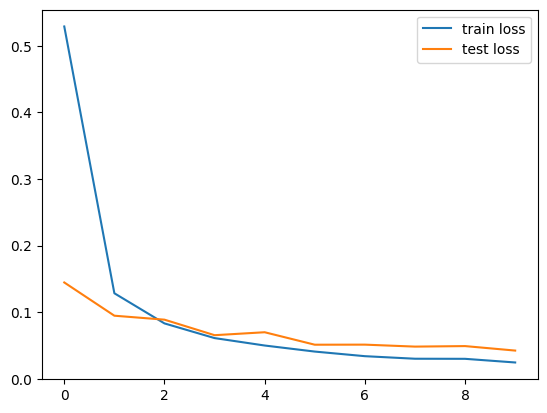

In [20]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show

In [21]:
# train accuracy

n_correct = 0
n_total = 0

for inputs, targets in train_loader:
  inputs, targets = inputs.to(device), targets.to(device)

  inputs = inputs.view(-1, 28, 28)

  p_train = model(inputs)
  _, predictions = torch.max(p_train, 1)

  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct / n_total

# test accuracy

n_correct = 0
n_total = 0

for inputs, targets in test_loader:
  inputs, targets = inputs.to(device), targets.to(device)

  inputs = inputs.view(-1, 28, 28)

  p_test = model(inputs)
  _, predictions = torch.max(p_test, 1)

  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct / n_total

print(f'Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Train Acc: 0.9937, Test Acc: 0.9880


In [22]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [38]:
x_test = test_dataset.data
y_test = test_dataset.targets
p_test = np.array([])

for inputs, targets in test_loader:
  inputs, targets = inputs.to(device), targets.to(device)
  inputs = inputs.view(-1, 28, 28)
  outputs = model(inputs)
  _, outputs = torch.max(outputs, 1)

  p_test = np.concatenate((p_test, outputs.cpu().numpy()))

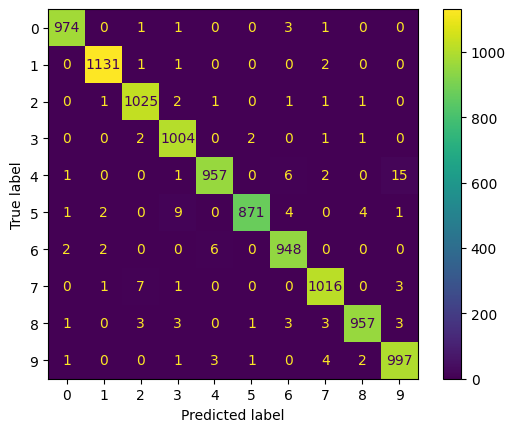

In [39]:
cm = confusion_matrix(y_test, p_test)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=np.unique(test_dataset.targets))
disp.plot()
plt.show()